In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image
import keras
import segmentation_models as sm
from keras import backend as K
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [5]:
K.set_image_data_format('channels_last')

In [6]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ElasticTransform(),
])

#model = sm.Unet(backbone_name='resnet18', classes=1,encoder_weights='imagenet', encoder_freeze=True)
#model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

In [56]:
def image_preprocessing(x):
    x = x/255. # rescale to [0,1]
    return(x)

def mask_preprocessing(x):
    #x = x[:,:,np.newaxis] # expand from (512,512) to (512,512,1)
    x = x/255. # rescale to [0,1]
    return(x)

In [57]:
img_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, 
                                  augment_seed=123,
                                  preprocess_input = image_preprocessing)
img_gen = img_data_gen.flow_from_directory('./data/img', 
                                           class_mode=None, 
                                           shuffle=True, 
                                           seed=123, 
                                           color_mode='rgb', 
                                           target_size=(512, 512),
                                           batch_size=8)
mask_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS,
                                   augment_seed=123,
                                   augment_mode='mask',
                                   preprocess_input = mask_preprocessing)
mask_gen = mask_data_gen.flow_from_directory('./data/msk', 
                                           class_mode=None, 
                                           shuffle=True, 
                                           seed=123, 
                                           color_mode='grayscale', 
                                           target_size=(512, 512),
                                           batch_size=8)

train_gen = zip(img_gen, mask_gen)

Found 6804 images belonging to 1 classes.
Found 6804 images belonging to 1 classes.


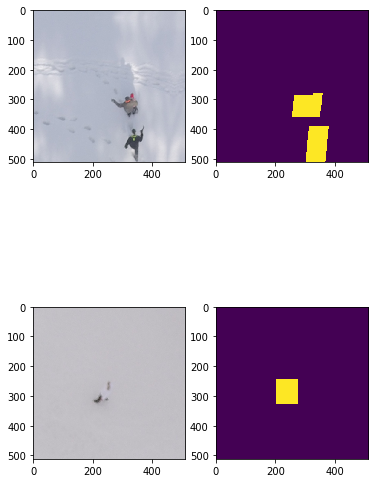

In [59]:
k = 2
image_batch, mask_batch = next(train_gen)
fix, ax = plt.subplots(k,2, figsize=(3*2,10))
for i in range(k):
    ax[i,0].imshow(image_batch[i,:,:,:])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [61]:
model = sm.Unet(backbone_name='resnet18', classes=1,encoder_weights='imagenet', encoder_freeze=True)
model.compile('Adam', 
              loss=sm.losses.binary_focal_dice_loss,
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score])

In [66]:
H = model.fit_generator(train_gen, 
                        steps_per_epoch=5,
                        epochs=1,
                        use_multiprocessing=True,
                        workers=4,
                        max_queue_size=4)

Epoch 1/1
5/5 [==============================] - 9s 2s/step - loss: 0.0656 - iou_score: 0.8858 - f1-score: 0.9394


In [71]:
from datetime import datetime
image_batch, mask_batch = next(train_gen)
start = datetime.now()
y_pred = model.predict_on_batch(np.expand_dims(image_batch[0,:,:,:], axis=0))
end = datetime.now()
print(end - start)
start = datetime.now()
y_pred2 = model.predict_on_batch(np.expand_dims(image_batch[1,:,:,:], axis=0))
end = datetime.now()
print(end - start)

0:00:00.034185
0:00:00.016039


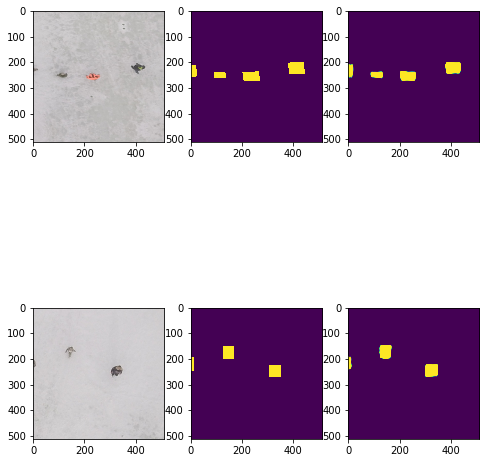

In [73]:
fix, ax = plt.subplots(2,3, figsize=(4*2,10))
ax[0,0].imshow(image_batch[0,:,:,:])
ax[0,1].imshow(mask_batch[0,:,:,0])
ax[0,2].imshow(y_pred[0,:,:,0])
ax[1,0].imshow(image_batch[1,:,:,:])
ax[1,1].imshow(mask_batch[1,:,:,0])
ax[1,2].imshow(y_pred2[0,:,:,0])
plt.show()

In [76]:
model.save('unet_resnet18.h5')

In [ ]:
# try om summer

In [83]:
TEST_AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5)
])

img_test_data_gen = ImageDataAugmentor(augment=TEST_AUGMENTATIONS, 
                                  augment_seed=123,
                                  preprocess_input = image_preprocessing)
img_test_gen = img_test_data_gen.flow_from_directory('./test_data/img', 
                                           class_mode=None, 
                                           shuffle=True, 
                                           seed=123, 
                                           color_mode='rgb', 
                                           target_size=(512, 512),
                                           batch_size=8)
mask_test_data_gen = ImageDataAugmentor(augment=TEST_AUGMENTATIONS,
                                   augment_seed=123,
                                   augment_mode='mask',
                                   preprocess_input = mask_preprocessing)
mask_test_gen = mask_test_data_gen.flow_from_directory('./test_data/msk', 
                                           class_mode=None, 
                                           shuffle=True, 
                                           seed=123, 
                                           color_mode='grayscale', 
                                           target_size=(512, 512),
                                           batch_size=8)

test_gen = zip(img_test_gen, mask_test_gen)

Found 4063 images belonging to 1 classes.
Found 4063 images belonging to 1 classes.


In [98]:
from datetime import datetime
image_batch, mask_batch = next(test_gen)
start = datetime.now()
y_pred = model.predict_on_batch(np.expand_dims(image_batch[0,:,:,:], axis=0))
end = datetime.now()
print(end - start)
start = datetime.now()
y_pred2 = model.predict_on_batch(np.expand_dims(image_batch[1,:,:,:], axis=0))
end = datetime.now()
print(end - start)
start = datetime.now()
y_pred3 = model.predict_on_batch(np.expand_dims(image_batch[2,:,:,:], axis=0))
end = datetime.now()
print(end - start)
start = datetime.now()
y_pred4 = model.predict_on_batch(np.expand_dims(image_batch[3,:,:,:], axis=0))
end = datetime.now()
print(end - start)

0:00:00.032058
0:00:00.016230
0:00:00.015864
0:00:00.016112


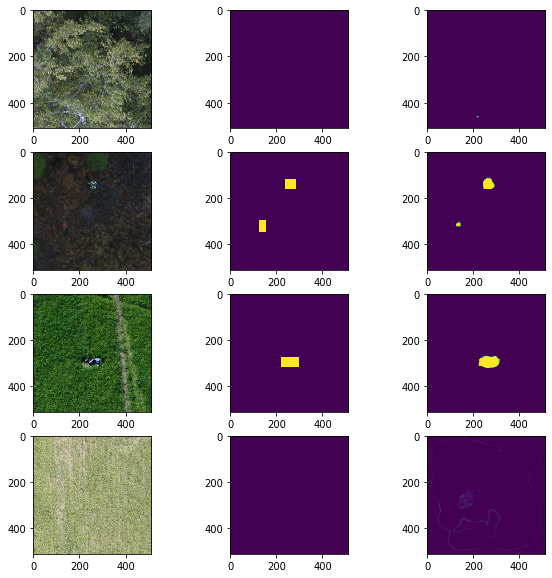

In [99]:
fix, ax = plt.subplots(4,3, figsize=(5*2,10))
ax[0,0].imshow(image_batch[0,:,:,:])
ax[0,1].imshow(mask_batch[0,:,:,0])
ax[0,2].imshow(y_pred[0,:,:,0])
ax[1,0].imshow(image_batch[1,:,:,:])
ax[1,1].imshow(mask_batch[1,:,:,0])
ax[1,2].imshow(y_pred2[0,:,:,0])
ax[2,0].imshow(image_batch[2,:,:,:])
ax[2,1].imshow(mask_batch[2,:,:,0])
ax[2,2].imshow(y_pred3[0,:,:,0])
ax[3,0].imshow(image_batch[3,:,:,:])
ax[3,1].imshow(mask_batch[4,:,:,0])
ax[3,2].imshow(y_pred4[0,:,:,0])
plt.show()

In [102]:
# try om spring

TEST_AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5)
])

img_test_data_gen2 = ImageDataAugmentor(augment=TEST_AUGMENTATIONS, 
                                  augment_seed=123,
                                  preprocess_input = image_preprocessing)
img_test_gen2 = img_test_data_gen2.flow_from_directory('./test_data2/img', 
                                           class_mode=None, 
                                           shuffle=True, 
                                           seed=123, 
                                           color_mode='rgb', 
                                           target_size=(512, 512),
                                           batch_size=8)
mask_test_data_gen2 = ImageDataAugmentor(augment=TEST_AUGMENTATIONS,
                                   augment_seed=123,
                                   augment_mode='mask',
                                   preprocess_input = mask_preprocessing)
mask_test_gen2 = mask_test_data_gen2.flow_from_directory('./test_data2/msk', 
                                           class_mode=None, 
                                           shuffle=True, 
                                           seed=123, 
                                           color_mode='grayscale', 
                                           target_size=(512, 512),
                                           batch_size=8)

test_gen2 = zip(img_test_gen2, mask_test_gen2)

Found 4328 images belonging to 1 classes.
Found 4328 images belonging to 1 classes.


In [105]:
from datetime import datetime
image_batch, mask_batch = next(test_gen2)
start = datetime.now()
y_pred = model.predict_on_batch(np.expand_dims(image_batch[0,:,:,:], axis=0))
end = datetime.now()
print(end - start)
start = datetime.now()
y_pred2 = model.predict_on_batch(np.expand_dims(image_batch[1,:,:,:], axis=0))
end = datetime.now()
print(end - start)
start = datetime.now()
y_pred3 = model.predict_on_batch(np.expand_dims(image_batch[2,:,:,:], axis=0))
end = datetime.now()
print(end - start)
start = datetime.now()
y_pred4 = model.predict_on_batch(np.expand_dims(image_batch[3,:,:,:], axis=0))
end = datetime.now()
print(end - start)

0:00:00.034680
0:00:00.015794
0:00:00.015832
0:00:00.015786


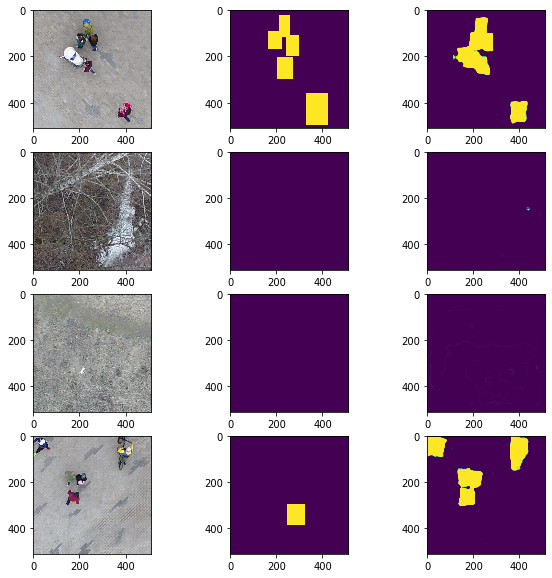

In [106]:
fix, ax = plt.subplots(4,3, figsize=(5*2,10))
ax[0,0].imshow(image_batch[0,:,:,:])
ax[0,1].imshow(mask_batch[0,:,:,0])
ax[0,2].imshow(y_pred[0,:,:,0])
ax[1,0].imshow(image_batch[1,:,:,:])
ax[1,1].imshow(mask_batch[1,:,:,0])
ax[1,2].imshow(y_pred2[0,:,:,0])
ax[2,0].imshow(image_batch[2,:,:,:])
ax[2,1].imshow(mask_batch[2,:,:,0])
ax[2,2].imshow(y_pred3[0,:,:,0])
ax[3,0].imshow(image_batch[3,:,:,:])
ax[3,1].imshow(mask_batch[4,:,:,0])
ax[3,2].imshow(y_pred4[0,:,:,0])
plt.show()